In [ ]:
import numpy as np
from tensorflow import keras
from scipy.io import loadmat
import os
from os import path
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


In [ ]:
#!unzip rawdata-20200330T180426Z-001.zip
from google.colab import drive
drive.mount('/content/gdrive')


In [ ]:
# initializer = keras.initializers.HeNormal()

# def make_cnn_model(image_size=(201, 201, 3), classes=2, summarize=True):
#     input_layer = keras.layers.Input(shape=image_size)
#     # block 0: conv-> strided_conv # change relu to LeakyRelu
#     x = keras.layers.Conv2D(16, 3, padding='same', activation='relu',kernel_initializer=initializer)(input_layer)
#     x = keras.layers.Conv2D(16, 3, strides=2, padding='same', activation='relu',kernel_initializer = initializer)(x)
#     # block 1: conv-> strided_conv
#     x = keras.layers.Conv2D(32, 3, padding='same', activation='relu',kernel_initializer=initializer)(x)
#     x = keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu',kernel_initializer=initializer)(x)
#     # block 2: conv-> strided_conv
#     x = keras.layers.Conv2D(64, 3, padding='same', activation='relu',kernel_initializer=initializer)(x)
#     x = keras.layers.Conv2D(64, 3, strides=2, padding='same', activation='relu',kernel_initializer=initializer)(x)
#     # block 3: conv-> strided_conv
#     x = keras.layers.Conv2D(128, 3, padding='same', activation='relu',kernel_initializer=initializer)(x)
#     x = keras.layers.Conv2D(128, 3, strides=2, padding='same', activation='relu',kernel_initializer=initializer)(x)
#     # block 4: flatten -> FC -> layer_norm -> FC -> out
#     x = keras.layers.Flatten()(x)
#     x = keras.layers.Dense(256, activation='relu',kernel_initializer=initializer)(x)

#     #x = keras.layers.BatchNormalization()(x)

#     output = keras.layers.Dense(classes, activation='softmax')(x)
#     model = keras.Model(inputs=input_layer, outputs=output)
#     if summarize:
#         model.summary()
#     return model

In [ ]:
# before we don't have seeds = totally random in each run, now we add seeds for different learning
initializer = keras.initializers.HeNormal(seed=4)

def make_cnn_model(image_size=(201, 201, 3), classes=2, summarize=True):
    input_layer = keras.layers.Input(shape=image_size)
    # block 0: conv-> strided_conv # change relu to LeakyRelu
    x = keras.layers.Conv2D(16, 3, padding='same', activation=keras.layers.LeakyReLU(alpha=0.001),kernel_initializer=initializer)(input_layer)
    x = keras.layers.Conv2D(16, 3, strides=2, padding='same', activation=keras.layers.LeakyReLU(alpha=0.001),kernel_initializer = initializer)(x)
    # block 1: conv-> strided_conv
    x = keras.layers.Conv2D(32, 3, padding='same', activation=keras.layers.LeakyReLU(alpha=0.001),kernel_initializer=initializer)(x)
    x = keras.layers.Conv2D(32, 3, strides=2, padding='same', activation=keras.layers.LeakyReLU(alpha=0.001),kernel_initializer=initializer)(x)
    # block 2: conv-> strided_conv
    x = keras.layers.Conv2D(64, 3, padding='same', activation=keras.layers.LeakyReLU(alpha=0.001),kernel_initializer=initializer)(x)
    x = keras.layers.Conv2D(64, 3, strides=2, padding='same', activation=keras.layers.LeakyReLU(alpha=0.001),kernel_initializer=initializer)(x)
    # block 3: conv-> strided_conv
    x = keras.layers.Conv2D(128, 3, padding='same', activation=keras.layers.LeakyReLU(alpha=0.001),kernel_initializer=initializer)(x)
    x = keras.layers.Conv2D(128, 3, strides=2, padding='same', activation=keras.layers.LeakyReLU(alpha=0.001),kernel_initializer=initializer)(x)
    # block 4: flatten -> FC -> layer_norm -> FC -> out
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation=keras.layers.LeakyReLU(alpha=0.001),kernel_initializer=initializer)(x)

    #x = keras.layers.BatchNormalization()(x)

    output = keras.layers.Dense(classes, activation='softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output)
    if summarize:
        model.summary()
    return model

In [ ]:
model = make_cnn_model()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 201, 201, 3)]     0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 201, 201, 16)      448       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 101, 101, 16)      2320      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 101, 101, 32)      4640      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 51, 51, 32)        9248      
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 51, 51, 64)        18496     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 26, 26, 64)        3692

In [ ]:
import time
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
 
datagen = ImageDataGenerator(
    # add a color aug?
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    #brightness_range=(0.2, 2),
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
    )


In [ ]:
def imdisp(im_seq_1):
  plt.figure(figsize=(15, 6)) # the first arg contral the horizontal distance
  for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(im_seq_1[i]) # 显示图片
    plt.axis('on') # 不显示坐标轴
    #plt.title('WBC')
  # for i in range(5):
  #   plt.subplot(2,5,i+6)|
  #   plt.imshow(im_seq_2[i+5]) # 显示图片
  #   plt.axis('on') # 不显示坐标轴
  #   #plt.title('RBC')
  plt.show() 

In [ ]:
from PIL import Image
from numpy import *
from scipy.ndimage import filters
def load_dataset(split=0.7, sum_channels=False, augment = False):
    ###################### generate train & validation ######################
    path = "/content/gdrive/My Drive/overlap/New setup/Labeled_data/NPY_1"
    positive_images = np.load(os.path.join(path, 'WBC.npy')).astype(np.float32)
    negative_images = np.load(os.path.join(path, 'RBC.npy')).astype(np.float32)

    print('original negative_images.shape = ')
    print(negative_images.shape)
    print('original positive_images.shape = ')
    print(positive_images.shape)
    print("Display Original Images:")
    imdisp(positive_images.astype(uint8))

    if sum_channels:
        # sum the last channel, keepdims keyword argument prevents collapsing the channel axis
        negative_images = np.sum(negative_images, axis=-1, keepdims=True)
        positive_images = np.sum(positive_images, axis=-1, keepdims=True)
        
    if augment:
      n_label = np.zeros(negative_images.shape[0])
      p_label = np.ones(positive_images.shape[0])
      f_neg=datagen.flow(negative_images,n_label,batch_size=negative_images.shape[0])
      f_pos=datagen.flow(positive_images,p_label,batch_size=positive_images.shape[0])
      aug_i=0
      while True:
          if aug_i==9:
              break
          time.sleep(1)
          aug_i +=1
          x_neg,y_neg=next(f_neg)
          x_pos,y_pos=next(f_pos)
          negative_images = np.insert(negative_images, 0, values=x_neg, axis=0)
          positive_images = np.insert(positive_images, 0, values=x_pos, axis=0)

    print('augemented negative_images.shape = ')
    print(negative_images.shape)
    print('augemented positive_images.shape = ')
    print(positive_images.shape)
    print("Display augmented Images:")
    imdisp(positive_images.astype(uint8))
   
    #shuffling along first axis
    np.random.seed(0) # shall we try other seeds
    np.random.shuffle(negative_images)
    np.random.shuffle(positive_images)
        
    train_negative_amnt = int(negative_images.shape[0]*split)
    negative_train_images = negative_images[:train_negative_amnt]
    negative_val_images = negative_images[train_negative_amnt:]

    train_positive_amnt = int(positive_images.shape[0]*split)
    positive_train_images = positive_images[:train_positive_amnt]
    positive_val_images = positive_images[train_positive_amnt:]

    print('negative_train_images number = ')
    print(negative_train_images.shape[0])
    print('negative_val_images number = ')
    print(negative_val_images.shape[0])

    return (negative_train_images, positive_train_images), (negative_val_images, positive_val_images)    

original negative_images.shape = 
(420, 201, 201, 3)
original positive_images.shape = 
(449, 201, 201, 3)
Display Original Images:


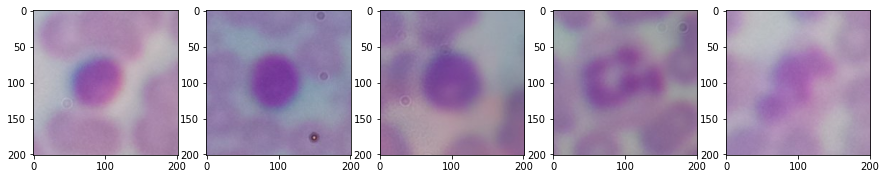

augemented negative_images.shape = 
(420, 201, 201, 3)
augemented positive_images.shape = 
(449, 201, 201, 3)
Display augmented Images:


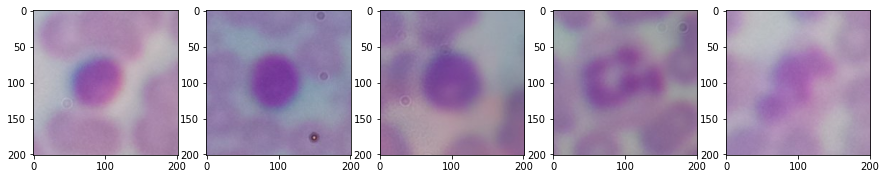

negative_train_images number = 
294
negative_val_images number = 
126


In [ ]:
(negative_train_images, positive_train_images), (negative_val_images, positive_val_images)= load_dataset(augment = False)

In [ ]:
# test different normalization methods

In [ ]:
def shot_noise(input_image, n):
  # x_axis = input_image.shape[0]
  # y_axis = input_image.shape[1]
  input_image = input_image+n*np.random.normal(loc=0.0, scale=np.sqrt(1/n*np.abs(input_image)*(1-1/n)*255/20000), size=[input_image.shape[0],input_image.shape[1],input_image.shape[2],input_image.shape[3],input_image.shape[4]])
  return input_image

def norm_after_aug(overlapped_images):
  overlapped_images = np.clip(overlapped_images.astype(np.float32), 0.0, 255)
  overlapped_images = overlapped_images.astype(np.float32)/255 - 0.5 
  return overlapped_images


In [ ]:
class OverlapGenerator(keras.utils.Sequence):
    def __init__(self, positive_images, negative_images, overlap_number=2, batch_size=32, normalize=False, add_noise=True, aug = True):
        assert (batch_size // 2)*2 == batch_size
        self.overlap_number = overlap_number
        self.positive_images = positive_images
        self.negative_images = negative_images
        #print(self.negative_images.shape)
        self.batch_size = batch_size
        self.normalize = normalize
        self.add_noise = add_noise
        # number of positive samples (*2 for total samples)
        self.num_batches = int(min(len(self.positive_images), len(self.negative_images))*2 // self.batch_size)
        self.samples = self.num_batches*self.batch_size//2
        self.labels = None
        self.overlapped_images = None
        self.on_epoch_end()
        self.aug = aug

    def on_epoch_end(self):
        positive_indices = np.arange(0, len(self.positive_images))
        negative_indices = np.arange(0, len(self.negative_images))
        # replace = False is critical
        positive_samples = np.random.choice(positive_indices, size=self.samples, replace=False) #positive - infected
        overlapped_images = []
        # if normalization:
        
        for i in range(self.samples): # generate digital overlapped infected images
            negative_overlap_indices = np.random.choice(negative_indices, size=self.overlap_number-1, replace=False)# select N-1 noninfected sample
            stack = np.concatenate([self.positive_images[positive_samples[i]:positive_samples[i]+1],self.negative_images[negative_overlap_indices]], axis=0)# concatenate 1 infected with N-1 noninfected
            overlapped_image = np.sum(stack, axis=0)
            overlapped_images.append(overlapped_image)

        for i in range(self.samples): # generate digital overlapped noninfected images:
            negative_overlap_indices = np.random.choice(negative_indices, size=self.overlap_number, replace=False)
            overlapped_image = np.sum(self.negative_images[negative_overlap_indices], axis=0)# the shape of overlapped image is 28*28*1
            overlapped_images.append(overlapped_image)

        overlapped_images = np.array(overlapped_images)
        print("The shape after overlap:")
        print(overlapped_images.shape)
        # img_dis = overlapped_images
        # img_dis = img_dis // self.overlap_number
        # imdisp(img_dis.astype(np.uint8))

        # 0 - noninfected, 1 - infected
        labels = np.zeros(self.samples*2)
        labels[0:self.samples] = 1
        # transfer the label to one-hot
        labels = keras.utils.to_categorical(labels)
        sample_indices = np.arange(0, len(overlapped_images))
        # ramdom shuffle
        np.random.shuffle(sample_indices)
        overlapped_images = overlapped_images[sample_indices]
        labels = labels[sample_indices]

        print("Before reshape The shape = ")
        print(overlapped_images.shape)
        # now re-shape to have batch_size samples in each
        # before reshape: (MxN, 201,201,3); after reshape: (M, N = 8, 201, 201, 3)
        overlapped_images = np.reshape(overlapped_images, (self.num_batches, -1, overlapped_images.shape[1],overlapped_images.shape[2],overlapped_images.shape[3] ))
        print("After reshape The shape = ")
        print(overlapped_images.shape)
        labels = np.reshape(labels, (self.num_batches, -1, 2))

        # add noise
        if self.add_noise:
            #overlapped_images = overlapped_images + 0.05*np.abs(np.random.normal(loc=0.0, scale=np.sqrt(np.mean(overlapped_images.flatten())), size=overlapped_images.shape))
            #overlapped_images = overlapped_images + 0.05*np.abs(np.random.normal(loc=0.0, scale=np.sqrt(np.abs(np.mean(overlapped_images.flatten()))), size=overlapped_images.shape))
            #print(overlapped_images.shape)
            overlapped_images = shot_noise(overlapped_images, self.overlap_number)
            overlapped_images = np.clip(overlapped_images, 0.0, 255*self.overlap_number)
            overlapped_images = (overlapped_images) / (255*self.overlap_number) # why 512 = 256*2 = 2^9
            #overlapped_images = np.clip(overlapped_images, 0.0, 1.0)
            # overlapped_images = np.int0(255*overlapped_images).astype(np.float32)/255 - 0.5 
            # figure()
            # imshow(overlapped_images.astype(np.uint8),vmin = 0, vmax = 255)

            overlapped_images = (255*overlapped_images).astype(np.uint8)
            # Q: after add the noise the pixel value may larger than 1 -> any effection?
        #show_in_sequence(overlapped_images[0,:,:,:,:], rgb = False)

        if self.normalize: # nolonger use this, use norma_aft_aug
            # print("show the pretrained overlapped image")
            # imdisp(overlapped_images[0,:,:,:])
            overlapped_images = np.clip(overlapped_images.astype(np.float32), 0.0, 255)
            overlapped_images = overlapped_images.astype(np.float32)/255 - 0.5 
            # Q: do this to each channel, will it change the original image property?
        self.labels = labels
        self.overlapped_images = overlapped_images

    def __len__(self):
        return self.num_batches

    # def __getitem__(self, index):
    def __getitem__(self, index):
      if self.aug: #if you want to see the augmented data, use generated_train.overlapped_images
        return next(datagen.flow(self.overlapped_images[index],shuffle=False)), self.labels[index]
      else:
        return self.overlapped_images[index].astype(np.uint8), self.labels[index]

In [ ]:
# for k in range(10):
#   generator_val = OverlapGenerator(positive_images=positive_val_images, negative_images=negative_val_images, overlap_number=k+1,batch_size=8, aug = False)


  0%|          | 0/1 [00:00<?, ?it/s]

N = 2
The shape after overlap:
(584, 201, 201, 3)
Before reshape The shape = 
(584, 201, 201, 3)
After reshape The shape = 
(73, 8, 201, 201, 3)


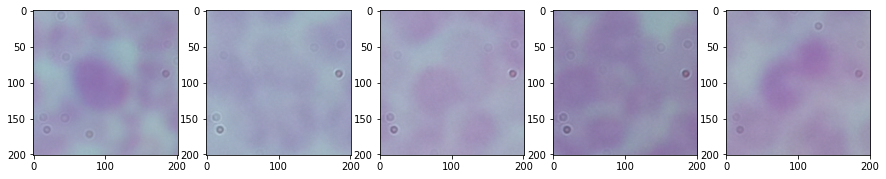

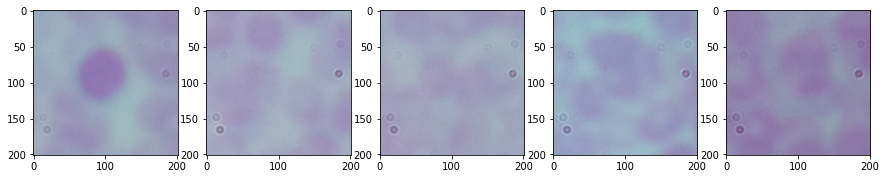

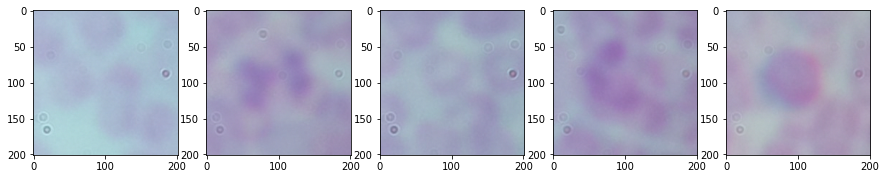

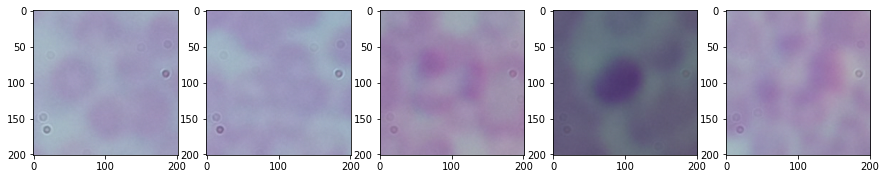

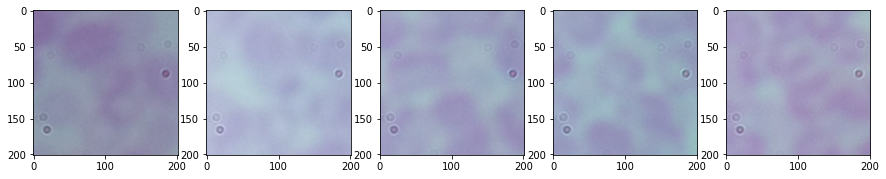

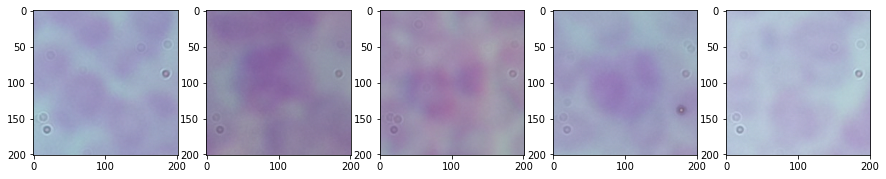

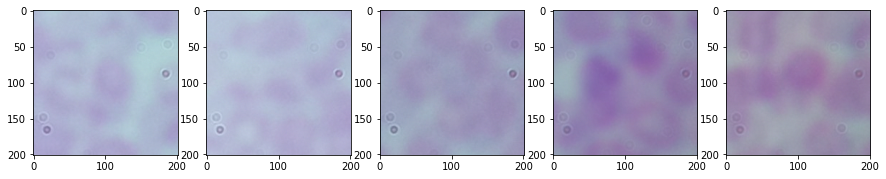

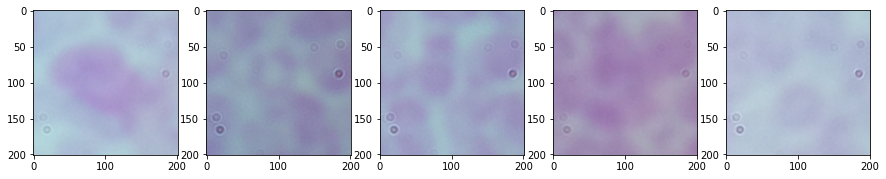

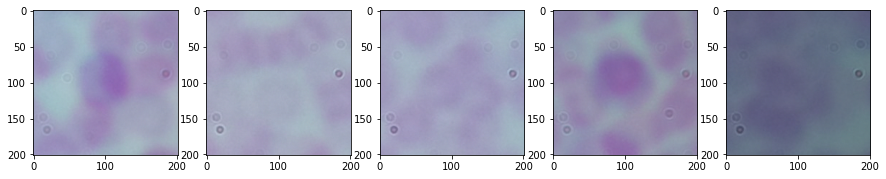

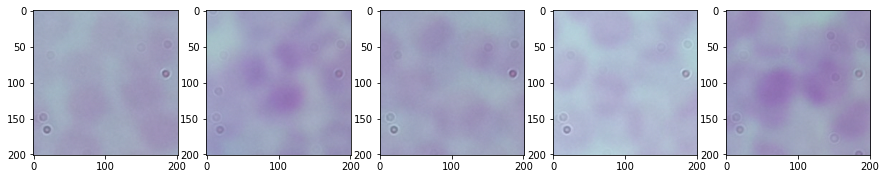

In [ ]:
####### Run to see the size #######
overlaps = np.arange(2, 3, 1)
train_accs = np.zeros_like(overlaps, dtype=np.float)
train_losses = np.zeros_like(overlaps, dtype=np.float)
test_accs = np.zeros_like(overlaps, dtype=np.float)
test_losses = np.zeros_like(overlaps, dtype=np.float)
val_accs = np.zeros_like(overlaps, dtype=np.float)
val_losses = np.zeros_like(overlaps, dtype=np.float)
for i, overlap in tqdm(enumerate(overlaps), total=len(overlaps)):
    print("N = "+str(overlaps[i]))
    generator_train = OverlapGenerator(positive_images=positive_train_images, negative_images=negative_train_images, overlap_number=overlap,batch_size=8,normalize=False,aug=True)
    for k in range(10):
        imdisp(generator_train.overlapped_images[k])
    # if self.normalize:
    #         overlapped_images = (overlapped_images) / (255*self.overlap_number) # why 512 = 256*2 = 2^9
    #         #overlapped_images = np.clip(overlapped_images, 0.0, 1.0)
    #         # overlapped_images = np.int0(255*overlapped_images).astype(np.float32)/255 - 0.5 
    #         # figure()
    #         # imshow(overlapped_images.astype(np.uint8),vmin = 0, vmax = 255)

    #         overlapped_images = (255*overlapped_images).astype(np.uint8)
    #         # print("show the pretrained overlapped image")
    #         # imdisp(overlapped_images[0,:,:,:])
    #         overlapped_images = overlapped_images.astype(np.float32)/255 - 0.5 
    #         # Q: do this to each channel, will it change the original image property?


    #generator_val = OverlapGenerator(positive_images=positive_val_images, negative_images=negative_val_images, overlap_number=overlap,batch_size=8,aug = False)
    # imdisp(generator_train.overlapped_images[0])
    # ####### model2 for validation #######
    # generator_val = OverlapGenerator(positive_images=positive_val_images, negative_images=negative_val_images, overlap_number=overlap,batch_size=8, aug = False)
    # model2 = make_cnn_model(summarize=False)
    # model2.compile(adam, loss='categorical_crossentropy',metrics=['accuracy'])
    # model2.fit(x=generator_train, validation_data=generator_val, epochs=50, verbose=1)
    # history2 = model2.history.history
    # val_accs[i] = np.mean(history2['val_accuracy'])
    # val_losses[i] = np.mean(history2['val_loss'])

The shape after overlap:
(584, 201, 201, 3)
Before reshape The shape = 
(584, 201, 201, 3)
After reshape The shape = 
(73, 8, 201, 201, 3)
The shape after overlap:
(248, 201, 201, 3)
Before reshape The shape = 
(248, 201, 201, 3)
After reshape The shape = 
(31, 8, 201, 201, 3)


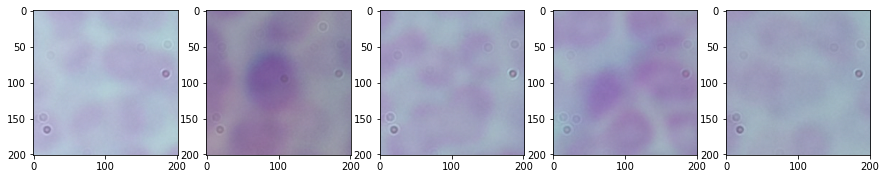

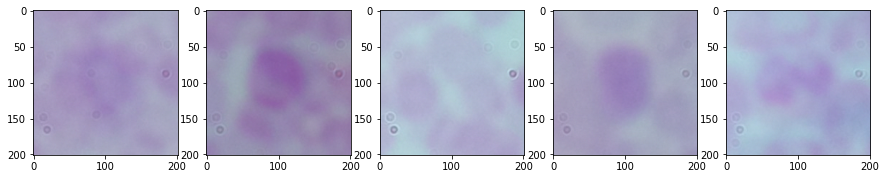

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/60
73/73 [==============================] - ETA: 0s - loss: 0.6823 - accuracy: 0.6301The shape after overlap:
(248, 201, 201, 3)
Before reshape The shape = 
(248, 201, 201, 3)
After reshape The shape = 
(31, 8, 201, 201, 3)
73/73 [==============================] - 55s 741ms/step - loss: 0.6823 - accuracy: 0.6301 - val_loss: 0.4369 - val_accuracy: 0.7984

Epoch 00001: val_accuracy improved from -inf to 0.79839, saving model to /content/gdrive/My Drive/overlap/New setup/9_27_test_n2_nobrightaug_uint8_Lrelu_weights_seed4.hdf5
The shape after overlap:
(584, 201, 201, 3)
Before reshape The shape = 
(584, 201, 201, 3)
After reshape The shape = 
(73, 8, 201, 201, 3)
Epoch 2/60
73/73 [==============================] - ETA: 0s - loss: 49.5888 - accuracy: 0.6130The shape after overlap:
(248, 201, 201, 3)
Before reshape The shape = 
(248, 201, 201, 3)
After reshape The shape = 
(31, 8, 201, 201, 3)
73/73 [==============================] - 56s 768ms/step - loss: 49.5888 - accuracy: 0.6130 

In [ ]:
################# run a single overlap number #####################
from tensorflow.keras.callbacks import ModelCheckpoint
overlaps = 2
train_accs = np.zeros_like(overlaps, dtype=np.float)
train_losses = np.zeros_like(overlaps, dtype=np.float)
val_accs = np.zeros_like(overlaps, dtype=np.float)
val_losses = np.zeros_like(overlaps, dtype=np.float)
test_accs = np.zeros_like(overlaps, dtype=np.float)
test_losses = np.zeros_like(overlaps, dtype=np.float)

# dynamic augmentation
generator_train = OverlapGenerator(positive_images=positive_train_images, negative_images=negative_train_images, overlap_number=overlaps,batch_size=8)
#print(next(generator_train).astype(np.uint8).shape)
#print(generator_train.overlapped_images.shape)
generator_val = OverlapGenerator(positive_images=positive_val_images, negative_images=negative_val_images, overlap_number=overlaps,batch_size=8, aug = False)
#generator_test = OverlapGenerator(positive_images=positive_test_images, negative_images=negative_test_images, overlap_number=overlaps,batch_size=8,aug = False)
imdisp(generator_train.overlapped_images[0])
imdisp(generator_val.overlapped_images[0])

#generator_train.overlapped_images = norm_after_aug(generator_train.overlapped_images).astype(np.float32)
#generator_val.overlapped_images = norm_after_aug(generator_val.overlapped_images).astype(np.float32)

generator_train.overlapped_images = norm_after_aug(generator_train.overlapped_images)
generator_val.overlapped_images = norm_after_aug(generator_val.overlapped_images)

model = make_cnn_model(summarize=False)
# model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])
adam = keras.optimizers.Adamax(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)#0.001 -> 0.0005
model.compile(adam, loss='categorical_crossentropy',metrics=['accuracy'])  

filepath="/content/gdrive/My Drive/overlap/New setup/9_27_test_n2_nobrightaug_uint8_Lrelu_weights_seed4.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,mode='max')
callbacks_list = [checkpoint]

history = model.fit(x=generator_train, validation_data=generator_val, epochs=60,callbacks=callbacks_list)
#model.save('my_model3.h5')   # HDF5 file, you have to pip3 install h5py if don't have it



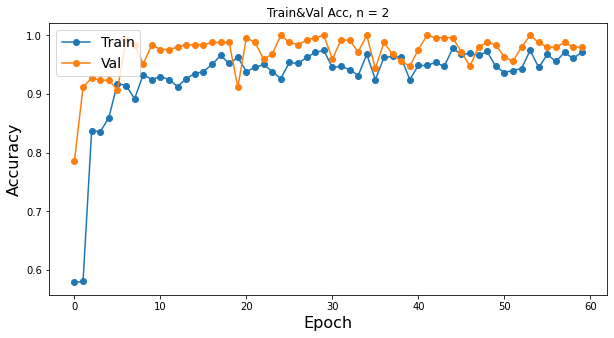

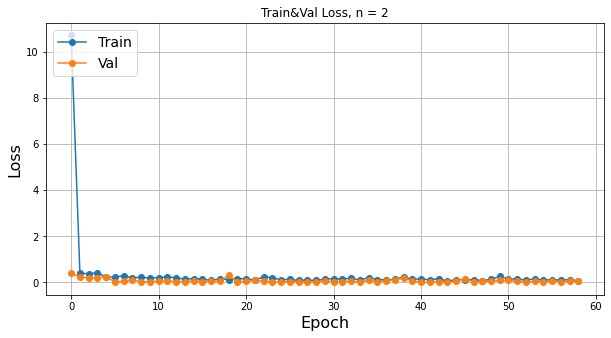

In [ ]:
# Plot training & test accuracy values
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'],marker='o')
plt.plot(history.history['val_accuracy'],marker='o')
#plt.title('Model accuracy')
plt.ylabel('Accuracy',fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.legend(['Train', 'Val'], loc='upper left',prop = {'size':14})
plt.title("Train&Val Acc, n = 2")
plt.show()

# Plot training & test loss values
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'][1:],marker='o')
plt.plot(history.history['val_loss'][1:],marker='o')
#plt.title('Model loss')
plt.ylabel('Loss',fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.legend(['Train', 'Val'], loc='upper left',prop = {'size':14})
plt.grid()
plt.title("Train&Val Loss, n = 2")
plt.show()

In [ ]:
model.save('/content/gdrive/My Drive/overlap/New setup/9_16_n2_uint8_Lrelu_weights.h5') 

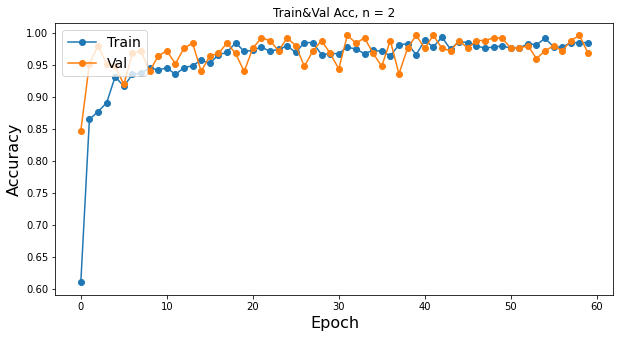

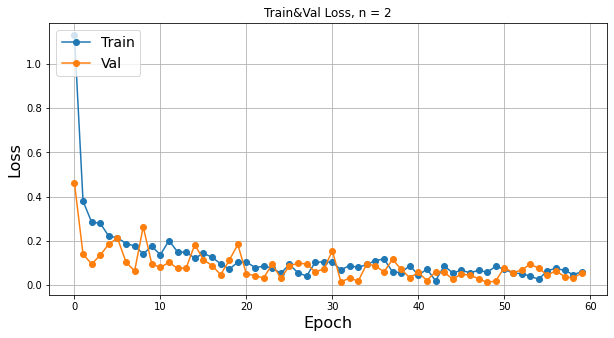

In [ ]:
# Plot training & test accuracy values
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'],marker='o')
plt.plot(history.history['val_accuracy'],marker='o')
#plt.title('Model accuracy')
plt.ylabel('Accuracy',fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.legend(['Train', 'Val'], loc='upper left',prop = {'size':14})
plt.title("Train&Val Acc, n = 2")
plt.show()

# Plot training & test loss values
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'],marker='o')
plt.plot(history.history['val_loss'],marker='o')
#plt.title('Model loss')
plt.ylabel('Loss',fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.legend(['Train', 'Val'], loc='upper left',prop = {'size':14})
plt.grid()
plt.title("Train&Val Loss, n = 2")
plt.show()

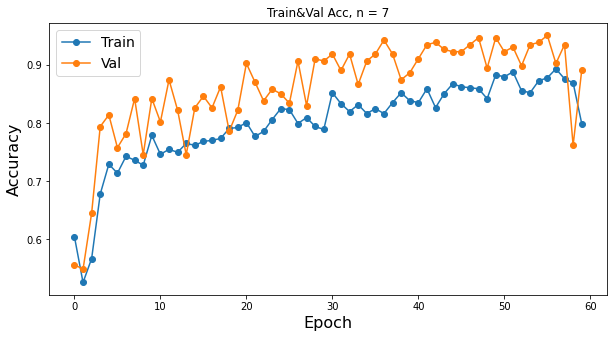

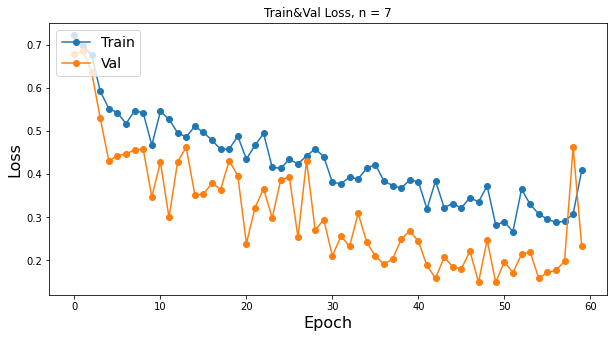

In [ ]:
# Plot training & test accuracy values
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'],marker='o')
plt.plot(history.history['val_accuracy'],marker='o')
#plt.title('Model accuracy')
plt.ylabel('Accuracy',fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.legend(['Train', 'Val'], loc='upper left',prop = {'size':14})
plt.title("Train&Val Acc, n = 7")
plt.show()

# Plot training & test loss values
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'],marker='o')
plt.plot(history.history['val_loss'],marker='o')
#plt.title('Model loss')
plt.ylabel('Loss',fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.legend(['Train', 'Val'], loc='upper left',prop = {'size':14})
plt.title("Train&Val Loss, n = 7")
plt.show()

In [ ]:
# plt.figure(figsize=(10,5))
# plt.xticks(overlaps)
# plt.plot(overlaps, train_accs, label='train acc', marker='o')
# plt.plot(overlaps, val_accs, label='val acc', marker='o')
# plt.plot(overlaps, test_accs, label='Test acc', marker='o')
# plt.xlabel("Number of overlaps",fontsize=16)
# plt.ylabel("Accuracy",fontsize=16)
# plt.legend(prop = {'size':14})

Select the best accuracy parameters for both test and validation

In [ ]:
################# run a single overlap number #####################
from tensorflow.keras.callbacks import ModelCheckpoint
overlaps = 2
train_accs = np.zeros_like(overlaps, dtype=np.float)
train_losses = np.zeros_like(overlaps, dtype=np.float)
val_accs = np.zeros_like(overlaps, dtype=np.float)
val_losses = np.zeros_like(overlaps, dtype=np.float)
test_accs = np.zeros_like(overlaps, dtype=np.float)
test_losses = np.zeros_like(overlaps, dtype=np.float)

# dynamic augmentation
generator_train = OverlapGenerator(positive_images=positive_train_images, negative_images=negative_train_images, overlap_number=overlaps,batch_size=8)
#print(next(generator_train).astype(np.uint8).shape)
#print(generator_train.overlapped_images.shape)
generator_val = OverlapGenerator(positive_images=positive_val_images, negative_images=negative_val_images, overlap_number=overlaps,batch_size=8, aug = False)
#generator_test = OverlapGenerator(positive_images=positive_test_images, negative_images=negative_test_images, overlap_number=overlaps,batch_size=8,aug = False)
imdisp(generator_train.overlapped_images[0])
imdisp(generator_val.overlapped_images[0])


generator_train.overlapped_images = norm_after_aug(generator_train.overlapped_images)
generator_val.overlapped_images = norm_after_aug(generator_val.overlapped_images)

model = make_cnn_model(summarize=False)
# model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])
adam = keras.optimizers.Adamax(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)#0.001 -> 0.0005
model.compile(adam, loss='categorical_crossentropy',metrics=['accuracy'])  

filepath="9_19_test_n2_brightaug_uint8_Lrelu_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,mode='max')
callbacks_list = [checkpoint]

history = model.fit(x=generator_train, validation_data=generator_val, epochs=60,callbacks=callbacks_list)
#model.save('my_model3.h5')   # HDF5 file, you have to pip3 install h5py if don't have it



In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
overlaps = np.arange(5, 8, 1)
train_accs = np.zeros_like(overlaps, dtype=np.float)
train_losses = np.zeros_like(overlaps, dtype=np.float)
# test_accs = np.zeros_like(overlaps, dtype=np.float)
# test_losses = np.zeros_like(overlaps, dtype=np.float)
val_accs = np.zeros_like(overlaps, dtype=np.float)
val_losses = np.zeros_like(overlaps, dtype=np.float)

train_accs_ave = np.zeros_like(overlaps, dtype=np.float)
train_losses_ave = np.zeros_like(overlaps, dtype=np.float)
# test_accs = np.zeros_like(overlaps, dtype=np.float)
# test_losses = np.zeros_like(overlaps, dtype=np.float)
val_accs_ave = np.zeros_like(overlaps, dtype=np.float)
val_losses_ave = np.zeros_like(overlaps, dtype=np.float)
for i, overlap in tqdm(enumerate(overlaps), total=len(overlaps)):
    generator_train = OverlapGenerator(positive_images=positive_train_images, negative_images=negative_train_images, overlap_number=overlap,batch_size=8)
    generator_val = OverlapGenerator(positive_images=positive_val_images, negative_images=negative_val_images, overlap_number=overlap,batch_size=8, aug = False)#,aug = False
    
    generator_train.overlapped_images = norm_after_aug(generator_train.overlapped_images)
    generator_val.overlapped_images = norm_after_aug(generator_val.overlapped_images)

    model = make_cnn_model(summarize=False)
    adam = keras.optimizers.Adamax(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    model.compile(adam, loss='categorical_crossentropy',metrics=['accuracy']) 

    filepath='/content/gdrive/My Drive/overlap/New setup/9_18_n=1_10_Lrelu_weights_model_n' + str(overlap)+'.hdf5'
    #filepath='n' + str(i+1)+"_weights.best.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,mode='max')
    callbacks_list = [checkpoint]

    #model.fit(x=generator_train, validation_data=generator_val, epochs=60) # if use callback need to add it
    model.fit(x=generator_train, validation_data=generator_val, epochs=60, callbacks=callbacks_list)

    history = model.history.history
    # train_accs[i] = np.mean(history['accuracy'][20:50])
    # train_losses[i] = np.mean(history['loss'][20:50])
    # val_accs[i] = np.mean(history['val_accuracy'][20:50])
    # val_losses[i] = np.mean(history['val_loss'][20:50])
    
    # the last accuracy
    train_accs[i] = history['accuracy'][59]
    train_losses[i] = history['loss'][59]
    val_accs[i] = history['val_accuracy'][59]
    val_losses[i] = history['val_loss'][59]
    
    # the average acc for last 5
    train_accs_ave[i] = np.mean(history['accuracy'][54:59])
    train_losses_ave[i] = np.mean(history['loss'][54:59])
    val_accs_ave[i] = np.mean(history['val_accuracy'][54:59])
    val_losses_ave[i] = np.mean(history['val_loss'][54:59])

np.save('/content/gdrive/My Drive/overlap/New setup/9_19_tacc567.npy', train_accs)
np.save('/content/gdrive/My Drive/overlap/New setup/9_19_vacc567.npy', val_accs)
np.save('/content/gdrive/My Drive/overlap/New setup/9_19_tacca567.npy', train_accs_ave)
np.save('/content/gdrive/My Drive/overlap/New setup/9_19_vacca567.npy', val_accs_ave)


  0%|          | 0/3 [00:00<?, ?it/s]

The shape after overlap:
(584, 201, 201, 3)
Before reshape The shape = 
(584, 201, 201, 3)
After reshape The shape = 
(73, 8, 201, 201, 3)
The shape after overlap:
(248, 201, 201, 3)
Before reshape The shape = 
(248, 201, 201, 3)
After reshape The shape = 
(31, 8, 201, 201, 3)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/60
73/73 [==============================] - ETA: 0s - loss: 0.7292 - accuracy: 0.5342The shape after overlap:
(248, 201, 201, 3)
Before reshape The shape = 
(248, 201, 201, 3)
After reshape The shape = 
(31, 8, 201, 201, 3)
73/73 [==============================] - 51s 691ms/step - loss: 0.7292 - accuracy: 0.5342 - val_loss: 0.6819 - val_accuracy: 0.5161

Epoch 00001: val_accuracy improved from -inf to 0.51613, saving model to /content/gdrive/My Drive/overlap/New setup/9_18_n=1_10_Lrelu_weights_model_n5.hdf5
The shape after overlap:
(584, 201, 201, 3)
Before reshape The shape = 
(584, 201, 201, 3)
After reshape The shape = 
(73, 8, 201, 201, 3)
Epoch 2/60
73/73 [==============================] - ETA: 0s - loss: 6.1913 - accuracy: 0.5086The shape after overlap:
(248, 201, 201, 3)
Before reshape The shape = 
(248, 201, 201, 3)
After reshape The shape = 
(31, 8, 201, 201, 3)
73/73 [==============================] - 53s 726ms/step - loss: 6.1913 - accuracy: 0.5086 - val_loss: 0.5739

In [ ]:
np.save('9_18_tacc.npy', train_accs)
np.save('9_18_vacc.npy', val_accs)
np.save('9_18_tacca.npy', train_accs_ave)
np.save('9_18_vacca.npy', val_accs_ave)

plt.figure(figsize=(10,5))
plt.xticks(overlaps)
plt.plot(overlaps, train_accs, label='train acc', marker='o')
plt.plot(overlaps, val_accs, label='val acc', marker='o')
#plt.plot(overlaps, test_accs, label='test acc', marker='o')
plt.xlabel("Number of overlaps",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.grid()
plt.title("Train&Val Acc V.S. Overlap Number n")
plt.legend(prop = {'size':14})

plt.figure(figsize=(10,5))
plt.xticks(overlaps)
plt.plot(overlaps, train_accs_ave, label='train acc', marker='o')
plt.plot(overlaps, val_accs_ave, label='val acc', marker='o')
#plt.plot(overlaps, test_accs, label='test acc', marker='o')
plt.xlabel("Number of overlaps",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.grid()
plt.title("Train&Val Acc V.S. Overlap Number n")
plt.legend(prop = {'size':14})

Select the final accuracy for both test and validation

In [ ]:
####### if we select the final accuracy for both test and validation #######
overlaps = np.arange(1, 6, 1)
train_accs = np.zeros_like(overlaps, dtype=np.float)
train_losses = np.zeros_like(overlaps, dtype=np.float)
test_accs = np.zeros_like(overlaps, dtype=np.float)
test_losses = np.zeros_like(overlaps, dtype=np.float)
val_accs = np.zeros_like(overlaps, dtype=np.float)
val_losses = np.zeros_like(overlaps, dtype=np.float)
for i, overlap in tqdm(enumerate(overlaps), total=len(overlaps)):
    generator_train = OverlapGenerator(positive_images=positive_train_images, negative_images=negative_train_images, overlap_number=overlap,batch_size=8)
    generator_val = OverlapGenerator(positive_images=positive_val_images, negative_images=negative_val_images, overlap_number=overlap,batch_size=8,aug = False)

    model = make_cnn_model(summarize=False)
    adam = keras.optimizers.Adamax(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    model.compile(adam, loss='categorical_crossentropy',metrics=['accuracy']) 
    model.fit(x=generator_train, validation_data=generator_val, epochs=60, verbose=1)
    history = model.history.history
    # train_accs[i] = np.mean(history['accuracy'][20:50])
    # train_losses[i] = np.mean(history['loss'][20:50])
    # val_accs[i] = np.mean(history['val_accuracy'][20:50])
    # val_losses[i] = np.mean(history['val_loss'][20:50])

    train_accs[i] = history['accuracy'][59]
    train_losses[i] = history['loss'][59]
    val_accs[i] = history['val_accuracy'][59]
    val_losses[i] = history['val_loss'][59]
    pt = '/content/gdrive/My Drive/overlap/New setup/new_my_model_n' + str(i+1)+'.h5'
    model.save(pt) 
    # ####### model2 for validation #######
    # generator_val = OverlapGenerator(positive_images=positive_val_images, negative_images=negative_val_images, overlap_number=overlap,batch_size=8, aug = False)
    # model2 = make_cnn_model(summarize=False)
    # model2.compile(adam, loss='categorical_crossentropy',metrics=['accuracy'])
    # model2.fit(x=generator_train, validation_data=generator_val, epochs=50, verbose=1)
    # history2 = model2.history.history
    # val_accs[i] = np.mean(history2['val_accuracy'])
    # val_losses[i] = np.mean(history2['val_loss'])

Before reshape The shape = 
(584, 201, 201, 3)
After reshape The shape = 
(73, 8, 201, 201, 3)
Before reshape The shape = 
(248, 201, 201, 3)
After reshape The shape = 
(31, 8, 201, 201, 3)
Epoch 1/60
73/73 [==============================] - ETA: 0s - loss: 0.7948 - accuracy: 0.6500Before reshape The shape = 
(248, 201, 201, 3)
After reshape The shape = 
(31, 8, 201, 201, 3)
73/73 [==============================] - 46s 616ms/step - loss: 0.7914 - accuracy: 0.6513 - val_loss: 0.2280 - val_accuracy: 0.8992
Before reshape The shape = 
(584, 201, 201, 3)
After reshape The shape = 
(73, 8, 201, 201, 3)
Epoch 2/60
73/73 [==============================] - ETA: 0s - loss: 0.2018 - accuracy: 0.9065Before reshape The shape = 
(248, 201, 201, 3)
After reshape The shape = 
(31, 8, 201, 201, 3)
73/73 [==============================] - 44s 608ms/step - loss: 0.2011 - accuracy: 0.9070 - val_loss: 0.0772 - val_accuracy: 0.9718
Before reshape The shape = 
(584, 201, 201, 3)
After reshape The shape = 
(

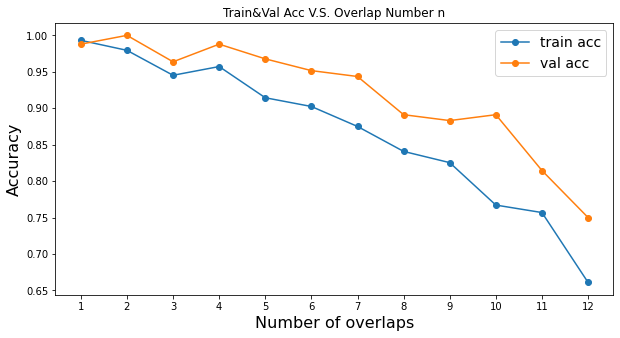

In [ ]:
plt.figure(figsize=(10,5))
plt.xticks(overlaps)
plt.plot(overlaps, train_accs, label='train acc', marker='o')
plt.plot(overlaps, val_accs, label='val acc', marker='o')
#plt.plot(overlaps, test_accs, label='test acc', marker='o')
plt.xlabel("Number of overlaps",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.title("Train&Val Acc V.S. Overlap Number n")
plt.legend(prop = {'size':14})

Select the average accuracy for both test and validation

In [ ]:
overlaps = np.arange(1, 8, 1)
train_accs = np.zeros_like(overlaps, dtype=np.float)
train_losses = np.zeros_like(overlaps, dtype=np.float)
test_accs = np.zeros_like(overlaps, dtype=np.float)
test_losses = np.zeros_like(overlaps, dtype=np.float)
val_accs = np.zeros_like(overlaps, dtype=np.float)
val_losses = np.zeros_like(overlaps, dtype=np.float)
for i, overlap in tqdm(enumerate(overlaps), total=len(overlaps)):
    generator_train = OverlapGenerator(positive_images=positive_train_images, negative_images=negative_train_images, overlap_number=overlap,batch_size=8)
    generator_val = OverlapGenerator(positive_images=positive_val_images, negative_images=negative_val_images, overlap_number=overlap,batch_size=8)#,aug = False

    model = make_cnn_model(summarize=False)
    adam = keras.optimizers.Adamax(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    model.compile(adam, loss='categorical_crossentropy',metrics=['accuracy']) 
    model.fit(x=generator_train, validation_data=generator_val, epochs=60, verbose=1)
    history = model.history.history
    train_accs[i] = np.mean(history['accuracy'][54:59])
    train_losses[i] = np.mean(history['loss'][54:59])
    val_accs[i] = np.mean(history['val_accuracy'][54:59])
    val_losses[i] = np.mean(history['val_loss'][54:59])

In [ ]:
plt.figure(figsize=(10,5))
plt.xticks(overlaps)
plt.plot(overlaps, train_accs, label='train acc', marker='o')
plt.plot(overlaps, val_accs, label='val acc', marker='o')
#plt.plot(overlaps, test_accs, label='test acc', marker='o')
plt.xlabel("Number of overlaps",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.title("Train&Val Acc V.S. Overlap Number n")
plt.legend(prop = {'size':14})

In [ ]:
generator_train.overlapped_images.shape

(73, 8, 201, 201, 3)

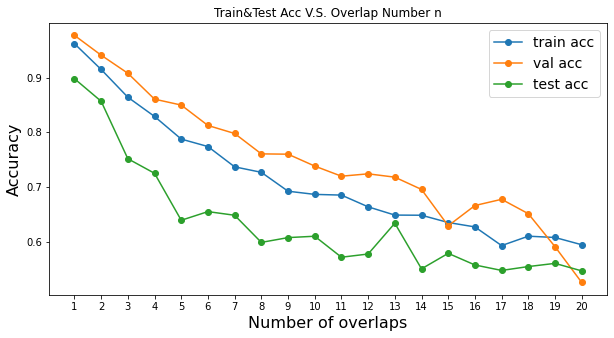

In [ ]:
plt.figure(figsize=(10,5))
plt.xticks(overlaps)
plt.plot(overlaps, train_accs, label='train acc', marker='o')
plt.plot(overlaps, val_accs, label='val acc', marker='o')
plt.plot(overlaps, test_accs, label='test acc', marker='o')
plt.xlabel("Number of overlaps",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.title("Train&Test Acc V.S. Overlap Number n")
plt.legend(prop = {'size':14})

In [ ]:
np.savetxt('3_new_mean_train_acc.csv', train_accs, delimiter = ',')
np.savetxt('3_new_mean_test_acc.csv', test_accs, delimiter = ',')
np.savetxt('3_new_mean_val_acc.csv', val_accs, delimiter = ',')

In [ ]:
def show_in_sequence(image_sequence, rgb = False):
    #plt.figure(figsize = [8, 8])
    for indexs in range(8):
        plt.subplot(2,4,indexs+1)
        if rgb:
            plt.imshow(image_sequence[indexs,:,:,:])
        else:
            plt.imshow(image_sequence[indexs,:,:,0])
        plt.axis('off')
    plt.show()

(507, 28, 28, 1)
(40, 28, 28, 1)
(218, 28, 28, 1)
n = 7----- True Negative
predict_value =0.07643366605043411


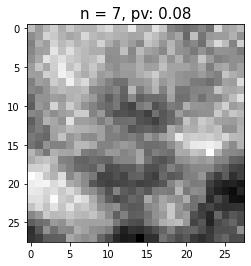

n = 7----- False Negative
predict_value =0.26339682936668396


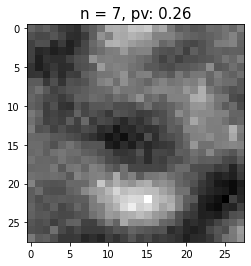

n = 7----- True Negative
predict_value =0.3445609211921692


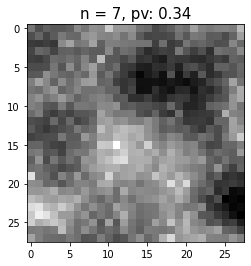

n = 7----- True Negative
predict_value =0.04524320736527443


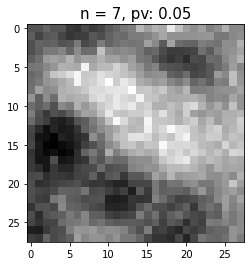

n = 7----- True Positive
predict_value =0.703931987285614


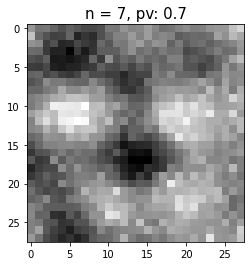

n = 7----- Flase Positive
predict_value =0.5634881258010864


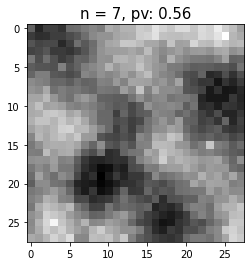

n = 7----- True Positive
predict_value =0.6354990601539612


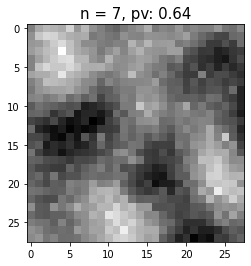

n = 7----- Flase Positive
predict_value =0.5827670097351074


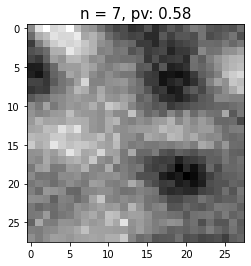

n = 7----- True Positive
predict_value =0.8142668604850769


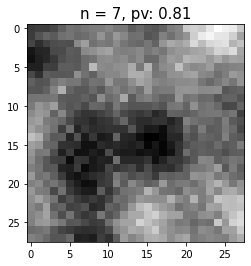

n = 7----- False Negative
predict_value =0.12775321304798126


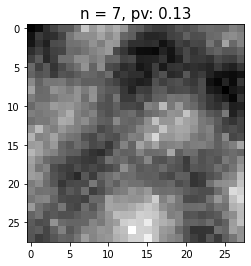

n = 7----- Flase Positive
predict_value =0.5867657661437988


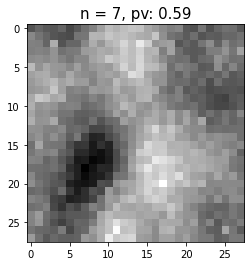

n = 7----- False Negative
predict_value =0.13888368010520935


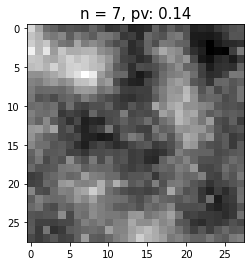

In [ ]:
################## use bestmodel for right&wrong classification####################
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
overlaps = np.arange(7, 8, 1)
#ww = np.zeros_like(overlaps, dtype=np.float)

test_real_label = []
test_pv = []
val_real_label = []
val_pv = []

for i, overlap in tqdm(enumerate(overlaps), total=len(overlaps)):
    generator_train = OverlapGenerator(positive_images=positive_train_images, negative_images=negative_train_images, overlap_number=overlap,batch_size=8)
    generator_test = OverlapGenerator(positive_images=positive_test_images, negative_images=negative_test_images, overlap_number=overlap,batch_size=8,aug = False)
    generator_val = OverlapGenerator(positive_images=positive_val_images, negative_images=negative_val_images, overlap_number=overlap,batch_size=8, aug = False)
   
    i = overlap - 1
    filepath=str(i+1)+"_weights.best.hdf5"

    model_for_predict = load_model("/content/gdrive/My Drive/overlap/"+filepath)

    Data = generator_train
    bnum = Data.labels.shape[0]
    #bnum = 121
    bsize = 8
    model = model_for_predict
    predict_result = np.zeros((bnum,bsize), dtype=np.int)
    predict_r2 = np.zeros((bnum,bsize), dtype=np.float)
    real_label = np.zeros((bnum,bsize), dtype=np.int)
    savepath = "/content/gdrive/My Drive/overlap/newoverlap/for_paper_figures/Figure 3/"

    number_sum_tp = 1
    number_sum_tn = 1
    number_sum_fn = 1
    number_sum_fp = 1

    for k in range(bnum):
      predict_result[k,:] = np.argmax(model.predict(Data.overlapped_images[k]), axis=1)# return 0 or 1
      predict_r2[k,:] = model.predict(Data.overlapped_images[k])[:,1]# return the probability of 1
      real_label[k,:] = np.argmax(Data.labels[k,:,:], axis=1)# since it's a heatmap,return the true label

      for j in range(bsize):
        # if number_sum > 3:
        #   break
        if (real_label[k, j] == 0) and (predict_result[k,j] == 1):
          if number_sum_fp > 3:
            break
          print("n = "+ str(i+1) + "----- Flase Positive")
          imname = "n = "+ str(i+1) + "_Flase Positive_"+str(number_sum_fp)+".png"
          plt.imsave(savepath+imname,Data.overlapped_images[k,j,:,:,0])
          number_sum_fp += 1
          print("predict_value ="+ str(predict_r2[k,j]))
          plt.figure()
          plt.gray()
          plt.title("n = "+str(i+1)+ ", pv: "+str(round(predict_r2[k,j], 2)),fontsize=15)
          plt.imshow(Data.overlapped_images[k,j,:,:,0])
          plt.show
          plt.pause(1)

        if (real_label[k, j] == 1) and (predict_result[k,j] == 1):
          if number_sum_tp > 3:
            break
          print("n = "+ str(i+1) + "----- True Positive")
          imname = "n = "+ str(i+1) + "_True Positive_"+str(number_sum_tp)+".png"
          number_sum_tp +=1
          print("predict_value ="+ str(predict_r2[k,j]))
          plt.figure()
          plt.gray()
          plt.title("n = "+str(i+1)+ ", pv: "+str(round(predict_r2[k,j], 2)),fontsize=15)
          plt.imshow(Data.overlapped_images[k,j,:,:,0])
          plt.imsave(savepath+imname,Data.overlapped_images[k,j,:,:,0])
          plt.show
          plt.pause(1)

        if (real_label[k, j] == 0) and (predict_result[k,j] == 0):
          if number_sum_tn > 3:
            break
          print("n = "+ str(i+1) + "----- True Negative")
          imname = "n = "+ str(i+1) + "_True Negative_"+str(number_sum_tn)+".png"
          plt.imsave(savepath+imname,Data.overlapped_images[k,j,:,:,0])
          number_sum_tn += 1
          print("predict_value ="+ str(predict_r2[k,j]))
          plt.figure()
          plt.gray()
          plt.title("n = "+str(i+1)+ ", pv: "+str(round(predict_r2[k,j], 2)),fontsize=15)
          plt.imshow(Data.overlapped_images[k,j,:,:,0])
          plt.show
          plt.pause(1)

        if (real_label[k, j] == 1) and (predict_result[k,j] == 0):
          if number_sum_fn > 3:
            break
          print("n = "+ str(i+1) + "----- False Negative")
          imname = "n = "+ str(i+1) + "_False Negative_"+str(number_sum_fn)+".png"
          plt.imsave(savepath+imname,Data.overlapped_images[k,j,:,:,0])
          number_sum_fn += 1
          print("predict_value ="+ str(predict_r2[k,j]))
          plt.figure()
          plt.gray()
          plt.title("n = "+str(i+1)+ ", pv: "+str(round(predict_r2[k,j], 2)),fontsize=15)
          plt.imshow(Data.overlapped_images[k,j,:,:,0])
          plt.show
          plt.pause(1)


          
    # pr = predict_result.flatten();
    # pr2 = predict_r2.flatten();
    # rl = real_label.flatten();
    
    # rl,pr, pr2=SS_test(model_for_predict, generator_test, 8,"Confusion Matrix of Test", normalize = False)
    # test_real_label.append(rl)
    # test_pv.append(pr2)
    

    # rl_,pr_, pr2_=SS_test(model_for_predict, generator_val, 8,"Confusion Matrix of Validation", normalize = False)
    # val_real_label.append(rl_)
    # val_pv.append(pr2_)

n = 1
(218, 28, 28, 1)


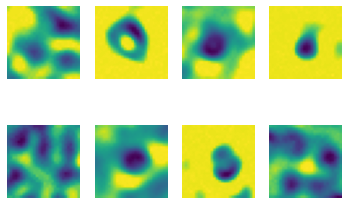

n = 2
(218, 28, 28, 1)


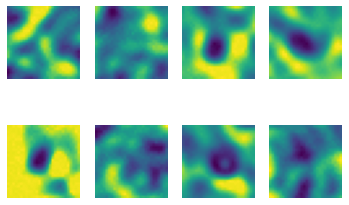

n = 3
(218, 28, 28, 1)


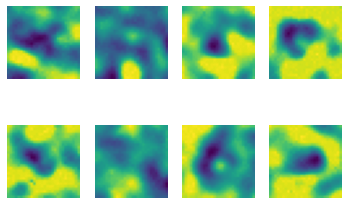

n = 4
(218, 28, 28, 1)


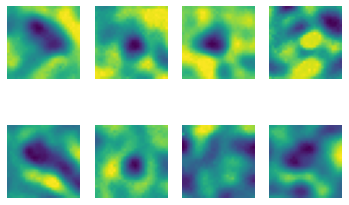

n = 5
(218, 28, 28, 1)


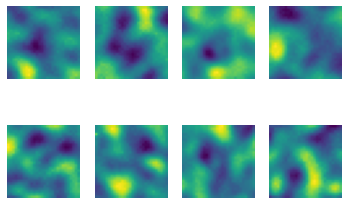

n = 6
(218, 28, 28, 1)


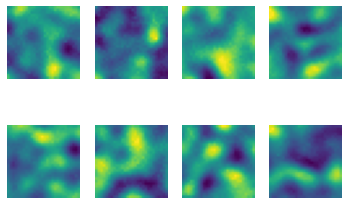

n = 7
(218, 28, 28, 1)


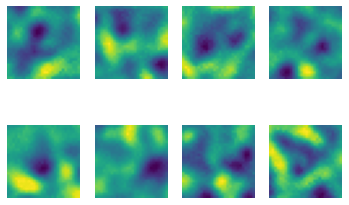

n = 8
(218, 28, 28, 1)


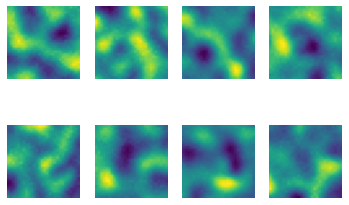

n = 9
(218, 28, 28, 1)


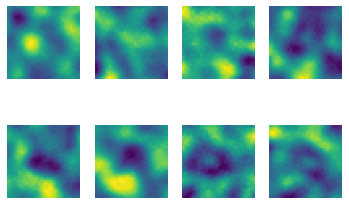

n = 10
(218, 28, 28, 1)


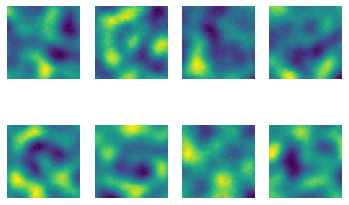

In [ ]:
for k in range(10):
  print("n = "+str(k +))
  generator_val = OverlapGenerator(positive_images=positive_val_images, negative_images=negative_val_images, overlap_number=k+1,batch_size=8, aug = False)
  plt.pause(1)